In [21]:
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
from torchvision.utils import save_image
from torch import optim

import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [22]:
import zipfile
import os

# Define your ZIP file name
zip_file = "archive.zip"  # Change this to your actual ZIP file name

# Extract it to a folder with the same name
extract_folder = zip_file.replace(".zip", "")  
# os.makedirs(extract_folder, exist_ok=True)

# # Extract files
# with zipfile.ZipFile(zip_file, "r") as zip_ref:
#     zip_ref.extractall(extract_folder)

print(f"Extracted to: {extract_folder}")


Extracted to: archive


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.current_device())  # Should return a number (GPU index)
print(torch.cuda.get_device_name(0))  # Should print your GPU model
print(torch.cuda.device_count())  # Number of GPUs available

initial_image_size=64

cuda
True
0
NVIDIA GeForce RTX 4090 Laptop GPU
1


In [24]:
transform = transforms.Compose([transforms.Resize((initial_image_size,initial_image_size)), transforms.CenterCrop(initial_image_size), transforms.ToTensor(), transforms.Normalize(mean= [0.5,0.5,0.5] , std=[0.5,0.5,0.5])])
# ToTensor => normalize data between 0 and 1
# Normalizer => normalize data between -1 and 1
train_dataset_img = datasets.ImageFolder(root=os.path.join(extract_folder, 'training'), transform = transform)
evaluation_dataset_img = datasets.ImageFolder(root=os.path.join(extract_folder, 'evaluation'),transform = transform)
validation_dataset_img = datasets.ImageFolder(root=os.path.join(extract_folder, 'validation'),transform = transform)

In [25]:
food_train_dataloader= DataLoader(train_dataset_img,batch_size=128, num_workers=16, pin_memory =True, shuffle=True)
len(food_train_dataloader)

78

In [26]:
def denormalize(input_image_tensors):
  mean=0.5
  std=0.5
  input_image_tensors = (input_image_tensors * mean) + std
  return input_image_tensors

<class 'torch.Tensor'>
3


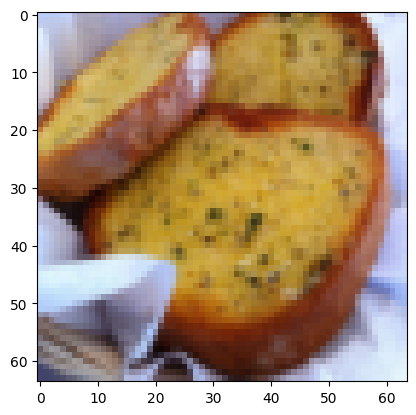

In [27]:
image_tensor , target=train_dataset_img[0]
print(type(image_tensor))
print(image_tensor.shape[0])
denorm=denormalize(image_tensor)
denormalized_image = denorm.permute(1, 2, 0).cpu().numpy()
plt.imshow(denormalized_image)

In [59]:
((255-4+2)+1)/2

127.0

In [28]:
class FoodDiscriminator(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.input_size = input_size
    self.channel = 3
    self.kernel_size=4
    self.stride=2
    self.padding = 1
    self.bias= False
    self.navigate_slope=0.2

    #input size (3,64,64)
    self.conv1 = nn.Conv2d(self.channel, 128, kernel_size= self.kernel_size, stride= self.stride, padding = self.padding, bias = self.bias)
    self.bn1=  nn.BatchNorm2d(128)
    self.relu= nn.LeakyReLU(self.navigate_slope, inplace=True)  #in GANS models we use leaky relu that doesn't 0 the values for negative x, an alpha (navigation_slope) is multiplied to y

    #input size (128,32,32)  stride 2 down scales it
    self.conv2= nn.Conv2d(128, 256, kernel_size= self.kernel_size, stride= self.stride, padding = self.padding, bias = self.bias)
    self.bn2=  nn.BatchNorm2d(256)

    #input size (256,16,16)  stride 2 down scales it
    self.conv3= nn.Conv2d(256, 512, kernel_size= self.kernel_size, stride= self.stride, padding = self.padding, bias = self.bias)
    self.bn3=  nn.BatchNorm2d(512)

    #input size (512,8,8)  stride 2 down scales it
    self.conv4= nn.Conv2d(512, 1024, kernel_size= self.kernel_size, stride= self.stride, padding = self.padding, bias = self.bias)
    self.bn4=  nn.BatchNorm2d(1024)

    # input (1024,4,4)
    self.fc= nn.Sequential(nn.Linear(in_features=16384, out_features=1), nn.Sigmoid())  # real or fake

  def forward(self, input_img):
    x = self.conv1(input_img)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu(x)

    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [75]:
1024*16*16

262144

In [29]:
class FoodGenerator(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.latent_size = latent_size
    self.kernel_size = 4
    self.stride = 2
    self.padding = 1
    self.bias = False

    # hout= (hin - 1) * stride + k - 2p

    #input: (latent_size, 1 , 1)
    self.model = nn.Sequential(
        nn.ConvTranspose2d(self.latent_size, 512, kernel_size= self.kernel_size, stride= 1, padding = 0, bias = self.bias),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        #input: (512, 4 , 4) => kernel size 4 and stride 1 , padding 0
        nn.ConvTranspose2d(512, 256, kernel_size= self.kernel_size, stride= self.stride , padding = self.padding , bias = self.bias),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        #input: (256, 8 , 8) => kernel size 4 and stride 2, padding 1
        nn.ConvTranspose2d(256, 128, kernel_size= self.kernel_size, stride= self.stride , padding = self.padding , bias = self.bias),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        #input: (128, 16 , 16) => kernel size 4 and stride 2, padding 1
        nn.ConvTranspose2d(128, 64, kernel_size= self.kernel_size, stride= self.stride , padding = self.padding , bias = self.bias),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        #input: (64, 32, 32) => kernel size 4 and stride 2, padding 1
        nn.ConvTranspose2d(64, 3, kernel_size= self.kernel_size, stride= self.stride , padding = self.padding , bias = self.bias),
        nn.Tanh() #to scale the values to -1 to 1

        #output size : 3*64*64

    ).to(device)

  def forward(self, input_img):
    input_img = self.model(input_img)
    return input_img

In [ ]:
ALL_FOOD_IMAGES=[]
image_size=64
def show_generated_samples(sample_imgs):
    grid = vutils.make_grid(denormalize(sample_imgs[:image_size].cpu()), normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

def save_generated_samples(epoch, sample_imgs):
    os.makedirs("generated_images", exist_ok=True)
    fname= os.path.join("generated_images", f"img-{epoch}.jpg")
    save_image(sample_imgs[:image_size], fname , normalize=True)

class FoodGan:
  def __init__(self, latent_size , lr= 0.0002, betas =(0.5, 0.999), batch_size=128, device=device): #betas default for Adam
    self.device = device
    self.latent_size = latent_size
    self.batch_size = batch_size

    self.generator = FoodGenerator(self.latent_size).to(device)
    self.discriminator = FoodDiscriminator(input_size = image_size).to(device)

    #two independent network, two optimizer
    self.opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas = betas)
    self.opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas = betas)

    self.criterian = nn.BCELoss()

    #initial random latent variable
    self.validation_noise= torch.randn(self.batch_size, latent_size,1,1,device=device)

    self.all_food_images=[]
    self.g_losses =[]
    self.d_losses = []

  def train_epoch(self, dataloader):
    self.generator.train()
    self.discriminator.train()
    for real_images, _ in dataloader:  # 128 image
      real_images = real_images.to(device)
      batch_size = len(real_images)

      self.opt_g.zero_grad()

      noise = torch.randn(batch_size, self.latent_size,1,1,device=device)
      fake_images= self.generator(noise)
      # print(f'fake image from generator {fake_images.shape}')
      preds = self.discriminator(fake_images)  #fake 0 or real 1
      g_loss = self.adversarial_loss(preds, torch.ones(batch_size, 1 , device= self.device), device=self.device)  #if pred is 1 then generator saying the image is real, and the loss will be 0
      g_loss.backward()
      self.opt_g.step()

      self.opt_d.zero_grad()

      real_image_label = self.discriminator(real_images)
      real_image_label_loss= self.adversarial_loss(real_image_label, torch.ones(batch_size,1, device= self.device), device=self.device)
      fake_image_label = self.discriminator(fake_images.detach())
      fake_image_label_loss= self.adversarial_loss(fake_image_label, torch.zeros(batch_size, 1 , device= self.device), device=self.device)

      d_loss= fake_image_label_loss + real_image_label_loss
      d_loss.backward()
      self.opt_d.step()

      self.g_losses.append(g_loss)
      self.d_losses.append(d_loss)

  def adversarial_loss(self, preds, targets, device):
      return self.criterian(preds, targets)

  def generate_samples(self, epoch):
      self.generator.eval()
      with torch.no_grad():
        sample_imgs = self.generator(self.validation_noise)
        self.all_food_images.append(sample_imgs.cpu())
        save_generated_samples(epoch, sample_imgs)
        show_generated_samples(sample_imgs)


In [16]:
for real_images, _ in food_train_dataloader:  # 128 image
  print(len(real_images))
  break

128


In [ ]:
latent_size= 64
batch_size=128
num_epochs=10

model = FoodGan(latent_size = latent_size, lr= 0.0002, betas =(0.5, 0.999), batch_size=128, device=device)
for epoch in range(num_epochs):
  model.train_epoch(food_train_dataloader)
  model.generate_samples(epoch)

  avg_g_loss= sum(model.g_losses[-len(food_train_dataloader):])/len(food_train_dataloader)
  avg_d_loss = sum(model.d_losses[-len(food_train_dataloader):])/len(food_train_dataloader)
  print(f"epoch {epoch+1}/{num_epochs} | G Loss {avg_g_loss:.4f} | D Loss {avg_d_loss:.4f}")


First epoch:

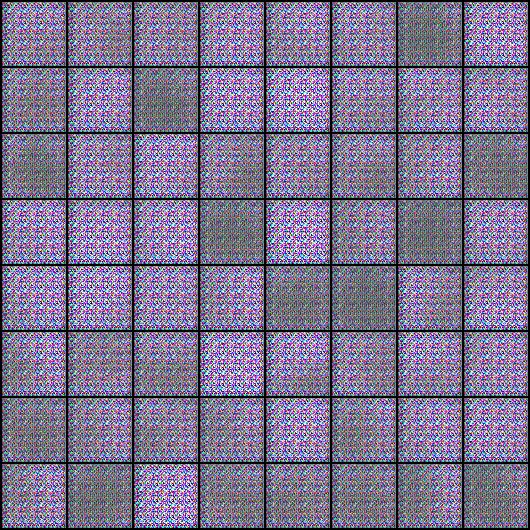


Epoch 73:

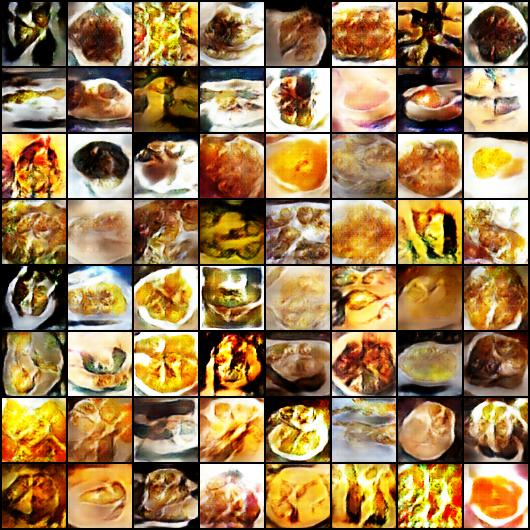

Other images are found in generated_images folder.